# Energy Consumption Prediction Using CNN and comparaison with LSTM

In [21]:
import pandas as pd 
import numpy as np 
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from skimpy import skim
import statsmodels.api as sm

In [22]:
df=pd.read_csv('../datasets/d5.csv')

In [23]:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour  
df['Weekday'] = df['Date'].dt.weekday  
df['Season'] = df['Date'].dt.month % 12 // 3 + 1 

season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['Season'] = df['Season'].map(season_map)


In [24]:
def zscore(s, window, thresh=1, return_all=False):
    roll = s.rolling(window=window, min_periods=1, center=True)
    avg = roll.mean()
    std = roll.std(ddof=0)
    z = s.sub(avg).div(std)
    m = z.between(-thresh, thresh)
    
    if return_all:
        return z, avg, std, m
    return s.where(m, avg)

df['Cleaned Energy Consumption'] = zscore(df['Energy Consumption'], window=7)
df = df[['Date', 'Cleaned Energy Consumption']]
df.rename(columns={'Cleaned Energy Consumption': 'Energy Consumption'}, inplace=True)



In [25]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['Energy Consumption'].values.reshape(-1, 1))


In [26]:
lookback = 15
X, y = [], []
for i in range(len(data) - lookback):
    X.append(data[i:i + lookback])
    y.append(data[i + lookback])

X, y = np.array(X), np.array(y)
X = torch.FloatTensor(X).view(-1, 1, lookback)
y = torch.FloatTensor(y) 

In [27]:
split_ratio = 0.8  # 80% training, 20% validation
split_index = int(len(X) * split_ratio)

X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

In [28]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)  # Output: [16, 15]
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)  # After pool1: [16, 7]
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)  # Output: [32, 7]
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)  # After pool2: [32, 3]

        # Adjust the input size for the first linear layer based on the output from the pooling
        self.fc1 = nn.Linear(32 * 3, 64)  # Adjusted input size for the first linear layer
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Shape: [batch_size, 16, 7]
        x = self.pool2(F.relu(self.conv2(x)))  # Shape: [batch_size, 32, 3]
        x = x.view(-1, 32 * 3)  # Flatten for the linear layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [29]:
model = CNN1D()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [10/100], Loss: 0.0404, Val Loss: 0.0688
Epoch [20/100], Loss: 0.0393, Val Loss: 0.0064
Epoch [30/100], Loss: 0.0250, Val Loss: 0.0548
Epoch [40/100], Loss: 0.0178, Val Loss: 0.0196
Epoch [50/100], Loss: 0.0124, Val Loss: 0.0146
Epoch [60/100], Loss: 0.0071, Val Loss: 0.0097
Epoch [70/100], Loss: 0.0031, Val Loss: 0.0044
Epoch [80/100], Loss: 0.0025, Val Loss: 0.0027
Epoch [90/100], Loss: 0.0025, Val Loss: 0.0027
Epoch [100/100], Loss: 0.0024, Val Loss: 0.0027


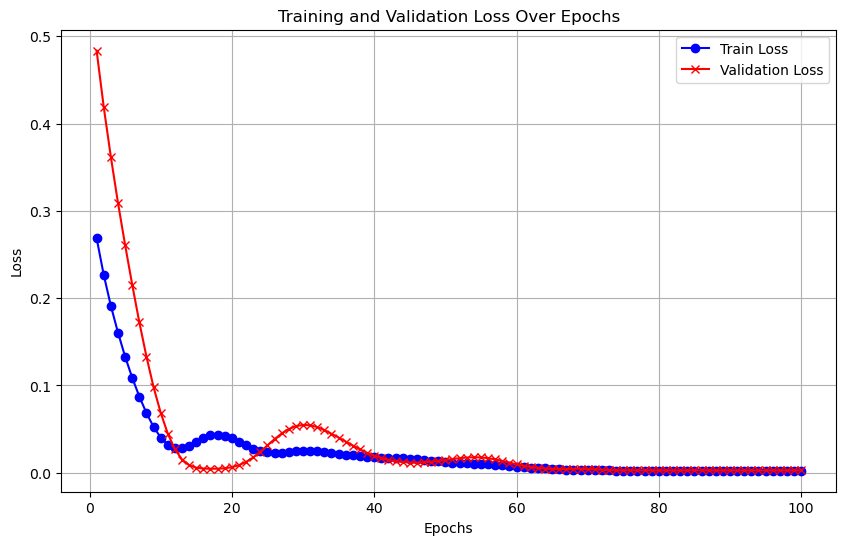

In [30]:
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    try:
        outputs = model(X)  # Training
        loss = criterion(outputs, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # Validation
        model.eval()  # Set to evaluation mode
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val.view(-1, 1))
            val_losses.append(val_loss.item())
    
    except RuntimeError as e:
        print(f"RuntimeError: {e}")
        print(f"X shape: {X.shape}, y shape: {y.shape}, outputs shape: {outputs.shape if 'outputs' in locals() else 'N/A'}")
        break

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plotting training and validation losses
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
import pandas as pd

# After training loop
with torch.no_grad():
    predictions = model(X)  # Use X directly without unsqueeze
    predictions = predictions.detach().numpy()  # Convert predictions to numpy array
    predictions = scaler.inverse_transform(predictions)  # Inverse transform to original scale

# Inverse transform actual values
y_actual = scaler.inverse_transform(y.view(-1, 1).detach().numpy())

# Create a DataFrame to compare actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_actual.flatten(),
    'Predicted': predictions.flatten()
})

# Calculate error (e.g., Absolute Error)
results_df['Error'] = abs(results_df['Actual'] - results_df['Predicted'])

# Print the DataFrame in a table format
print(results_df.to_string(index=True, float_format='%.4f'))


       Actual  Predicted   Error
0    300.8444   304.9474  4.1031
1    296.7380   304.5226  7.7847
2    310.4061   304.3013  6.1047
3    298.5789   304.3246  5.7457
4    305.6037   303.8369  1.7668
5    305.4067   303.6265  1.7802
6    306.5761   303.1832  3.3929
7    309.8964   303.0523  6.8441
8    307.1703   302.4873  4.6830
9    304.5450   303.1999  1.3451
10   311.4782   302.7589  8.7193
11   305.7044   303.0109  2.6935
12   307.2550   303.9693  3.2857
13   305.4874   304.4689  1.0185
14   308.9462   304.9609  3.9854
15   306.2126   305.4784  0.7342
16   312.7434   306.1594  6.5840
17   312.8184   306.8418  5.9766
18   313.2896   306.9785  6.3111
19   321.8898   307.5298 14.3600
20   301.8065   308.0770  6.2705
21   316.4506   308.7061  7.7446
22   311.0670   309.3644  1.7026
23   301.7636   309.2536  7.4900
24   317.3503   309.9913  7.3590
25   311.9952   310.5341  1.4611
26   317.7565   311.0461  6.7104
27   315.2111   310.9586  4.2525
28   313.6772   311.4580  2.2192
29   314.3

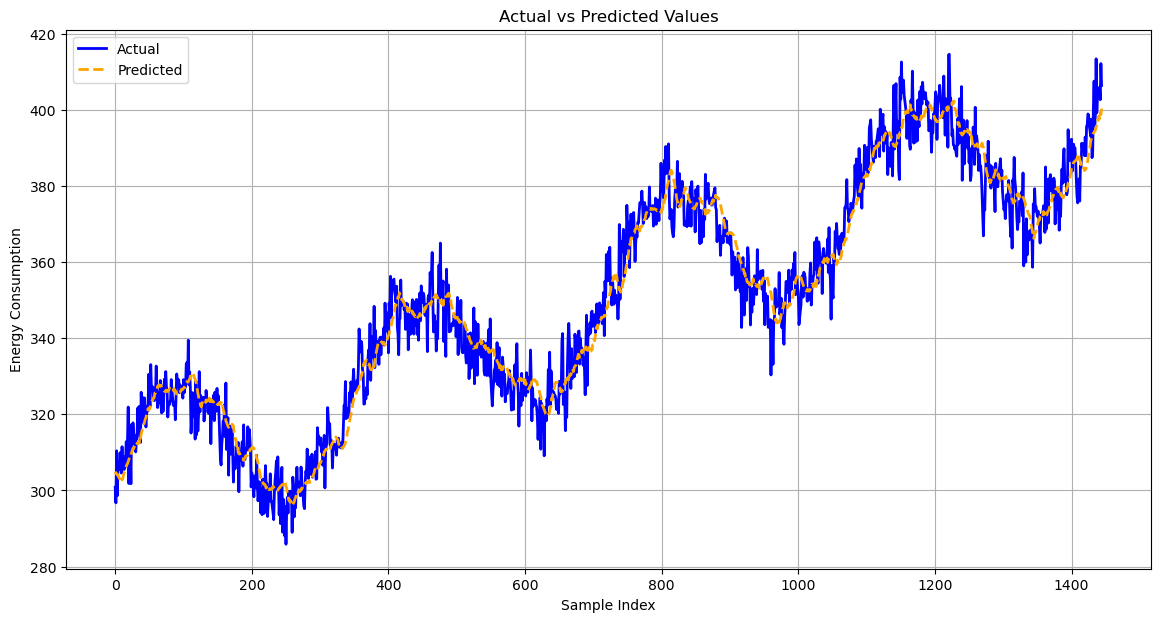

In [32]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values
plt.figure(figsize=(14, 7))

# Plot Actual Values
plt.plot(results_df['Actual'], label='Actual', color='blue', linewidth=2)

# Plot Predicted Values
plt.plot(results_df['Predicted'], label='Predicted', color='orange', linestyle='dashed', linewidth=2)

# Adding title and labels
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid()

# Show plot
plt.show()
